
<div style="text-align: center;">
    <h3>Algorithme de détection automatique de faux billets</h3>
    <img src="oncfm.JPG" />
</div>



### Import et lecture du fichier


In [35]:
# Importation des bibliothèques nécessaires
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor




# Spécification de l'emplacement du fichier CSV contenant les données
chemin_fichier = 'billets.csv'

# Chargement des données dans un DataFrame
donnees_billets = pd.read_csv(chemin_fichier, sep=';')

# Affichage des premières lignes du DataFrame pour vérifier le chargement des données
donnees_billets.head()


,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.81,104.86,104.95,4.52,2.89,112.83
1,True,171.46,103.36,103.66,3.77,2.99,113.09
2,True,172.69,104.48,103.50,4.40,2.94,113.16
3,True,171.36,103.91,103.94,3.62,3.01,113.51
4,True,171.73,104.28,103.46,4.04,3.48,112.54


Statistiques Descriptives


In [36]:
# Obtention des statistiques descriptives pour chaque colonne pour mieux comprendre les données
donnees_billets.describe()


,diagonal,height_left,height_right,margin_low,margin_up,length
count,1500.000000,1500.000000,1500.000000,1463.000000,1500.000000,1500.00000
mean,171.958440,104.029533,103.920307,4.485967,3.151473,112.67850
std,0.305195,0.299462,0.325627,0.663813,0.231813,0.87273
min,171.040000,103.140000,102.820000,2.980000,2.270000,109.49000
25%,171.750000,103.820000,103.710000,4.015000,2.990000,112.03000
50%,171.960000,104.040000,103.920000,4.310000,3.140000,112.96000
75%,172.170000,104.230000,104.150000,4.870000,3.310000,113.34000
max,173.010000,104.880000,104.950000,6.900000,3.910000,114.44000


Vérification des valeurs manquantes


In [37]:
# Calcul et affichage du nombre de valeurs manquantes pour chaque colonne
valeurs_manquantes = donnees_billets.isna().sum()
# Je les affiche pour vérification
print("Nombre de valeurs manquantes par colonne:")
print(valeurs_manquantes)


Nombre de valeurs manquantes par colonne:
is_genuine       0
diagonal         0
height_left      0
height_right     0
margin_low      37
margin_up        0
length           0
dtype: int64


Suppression des valeurs manquantes

In [38]:
# Suppression des lignes contenant des valeurs manquantes et stockage du résultat dans une nouvelle variable
donnees_sans_valeurs_na = donnees_billets.dropna(inplace=False)


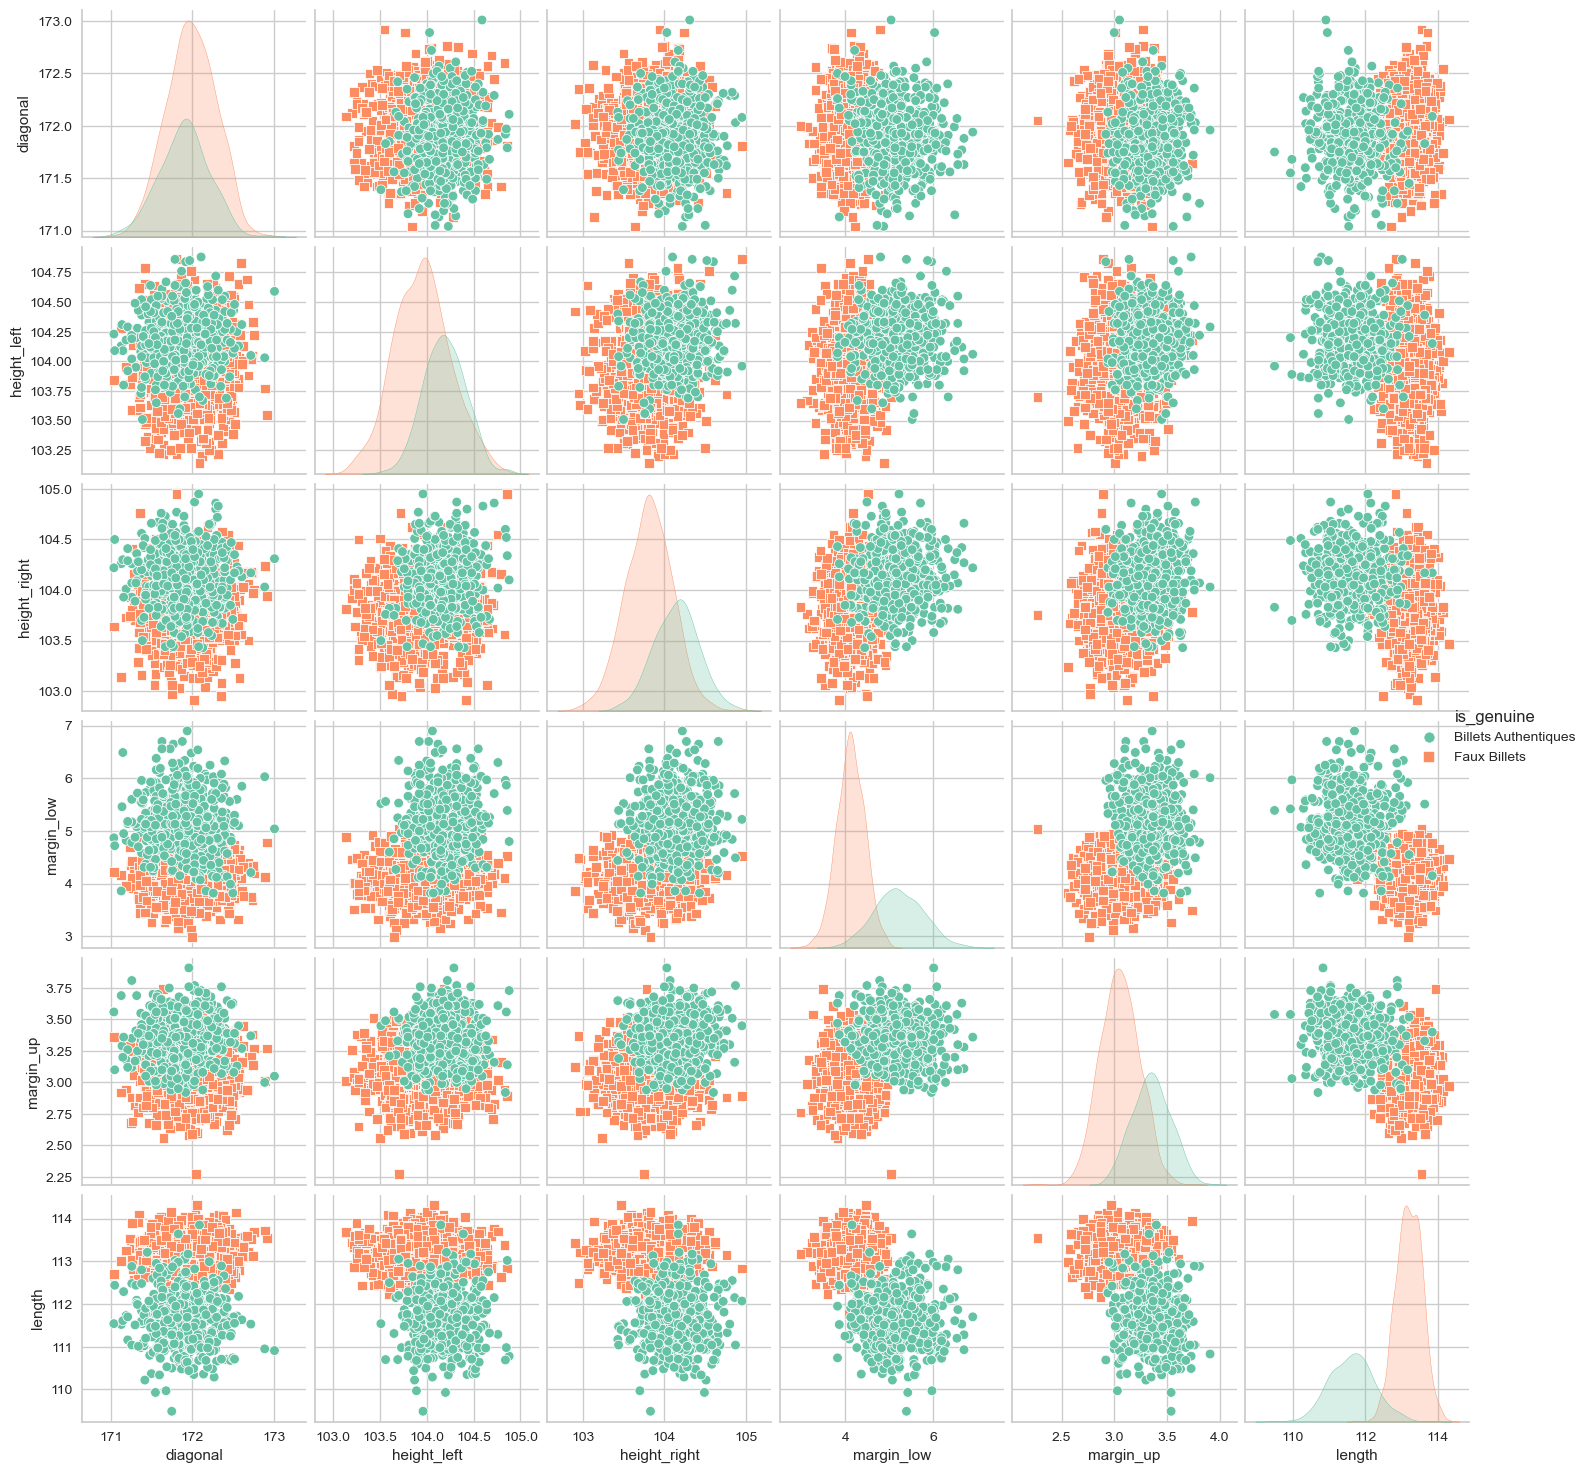

In [39]:
# Génération d'un pairplot pour visualiser les relations entre les différentes variables
# La couleur des points est définie selon la variable 'is_genuine'
pairplot_graphique = sns.pairplot(donnees_sans_valeurs_na, hue='is_genuine', diag_kind='kde', palette='Set2', markers=["o", "s"])

# Modification des étiquettes de la légende pour être plus explicites
nouvelles_etiquettes = ['Billets Authentiques', 'Faux Billets']
for texte, etiquette in zip(pairplot_graphique._legend.texts, nouvelles_etiquettes): 
    texte.set_text(etiquette)

# Affichage du pairplot
plt.show()


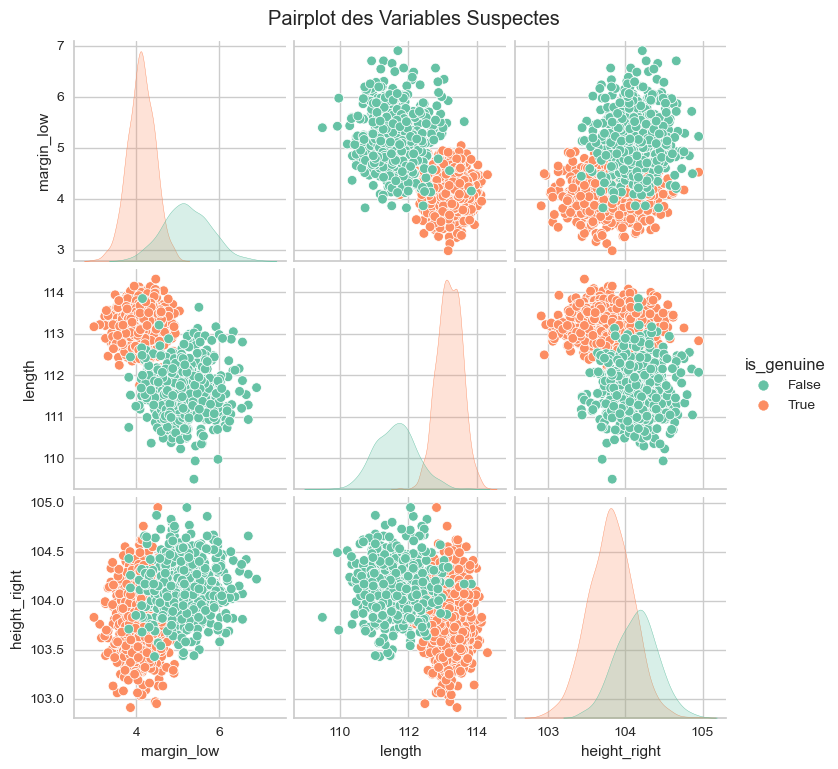

In [40]:
# Creating a pairplot focusing only on the 'suspect' variables
sns.pairplot(donnees_sans_valeurs_na, hue='is_genuine', palette='Set2', vars=['margin_low', 'length', 'height_right'])
plt.suptitle('Pairplot des Variables Suspectes', y=1.02)
plt.show()

## Analyse Statistique des Caractéristiques des Billets


In [41]:
# J'importe les bibliothèques nécessaires
from scipy.stats import levene, kstest, f_oneway, kruskal

# Prepare the data by separating it into genuine and fake bills
vrais_billets =donnees_sans_valeurs_na[donnees_sans_valeurs_na['is_genuine'] == True]
faux_billets = donnees_sans_valeurs_na[donnees_sans_valeurs_na['is_genuine'] == False]

# Je sélectionne les variables d'intérêt
variables_d_interet = ['margin_low', 'length', 'height_right']

# J'initialise des dictionnaires pour stocker les résultats des tests
resultats_levene = {}
resultats_ks = {}
resultats_anova_ou_kruskal = {}

# Je parcours chaque variable pour effectuer les tests
for caractéristique in variables_d_interet:
    # Je prépare les données pour la caractéristique spécifique
    vrais_billets_caract = vrais_billets[caractéristique]
    faux_billets_caract = faux_billets[caractéristique]
    
    # J'effectue le test de Levene pour évaluer l'égalité des variances
    stat_levene, p_value_levene = levene(vrais_billets_caract, faux_billets_caract)
    resultats_levene[caractéristique] = {'statistique': stat_levene, 'p_valeur': p_value_levene}
    
    # J'effectue le test de Kolmogorov-Smirnov pour la normalité
    stat_ks_vrais, p_value_ks_vrais = kstest(vrais_billets_caract, 'norm', args=(vrais_billets_caract.mean(), vrais_billets_caract.std()))
    stat_ks_faux, p_value_ks_faux = kstest(faux_billets_caract, 'norm', args=(faux_billets_caract.mean(), faux_billets_caract.std()))
    resultats_ks[caractéristique] = {'vrais': {'statistique': stat_ks_vrais, 'p_valeur': p_value_ks_vrais},
                                     'faux': {'statistique': stat_ks_faux, 'p_valeur': p_value_ks_faux}}
    
    # J'effectue le test ANOVA ou Kruskal-Wallis en fonction du résultat du test de Levene
    if p_value_levene > 0.05:
        stat_test, p_value_test = f_oneway(vrais_billets_caract, faux_billets_caract)
        nom_du_test = 'ANOVA'
    else:
        stat_test, p_value_test = kruskal(vrais_billets_caract, faux_billets_caract)
        nom_du_test = 'Kruskal-Wallis'
    
    resultats_anova_ou_kruskal[caractéristique] = {'statistique': stat_test, 'p_valeur': p_value_test, 'test_utilisé': nom_du_test}

# J'affiche les résultats
print("==== Résultats du test de Levene ====")
for caractéristique, resultat in resultats_levene.items():
    print(f"{caractéristique}: Statistique = {resultat['statistique']}, p-valeur = {resultat['p_valeur']}")

print("\n==== Résultats du test de Kolmogorov-Smirnov ====")
for caractéristique, resultat in resultats_ks.items():
    print(f"{caractéristique} (Vrais): Statistique = {resultat['vrais']['statistique']}, p-valeur = {resultat['vrais']['p_valeur']}")
    print(f"{caractéristique} (Faux): Statistique = {resultat['faux']['statistique']}, p-valeur = {resultat['faux']['p_valeur']}")

print("\n==== Résultats du test ANOVA/Kruskal-Wallis ====")
for caractéristique, resultat in resultats_anova_ou_kruskal.items():
    print(f"{caractéristique} ({resultat['test_utilisé']}): Statistique = {resultat['statistique']}, p-valeur = {resultat['p_valeur']}")


==== Résultats du test de Levene ====
margin_low: Statistique = 191.94004442079995, p-valeur = 4.2172159537971424e-41
length: Statistique = 173.00025579085374, p-valeur = 1.9997719360290065e-37
height_right: Statistique = 1.329665358267531, p-valeur = 0.24905337703204727

==== Résultats du test de Kolmogorov-Smirnov ====
margin_low (Vrais): Statistique = 0.023456907252793147, p-valeur = 0.6504147500883715
margin_low (Faux): Statistique = 0.03319807448497092, p-valeur = 0.6377258460975803
length (Vrais): Statistique = 0.03638935911409391, p-valeur = 0.1490807185552827
length (Faux): Statistique = 0.028814565254357993, p-valeur = 0.7974735714915859
height_right (Vrais): Statistique = 0.02751727395223219, p-valeur = 0.44614361453903095
height_right (Faux): Statistique = 0.02974780324005627, p-valeur = 0.7649587575163973

==== Résultats du test ANOVA/Kruskal-Wallis ====
margin_low (Kruskal-Wallis): Statistique = 828.742802832455, p-valeur = 3.040847316225815e-182
length (Kruskal-Wallis): S

Résumé du test de Kolmogorov-Smirnov (Normalité des données)
Toutes les p-valeurs sont supérieures à 0,05, ce qui indique que nous ne pouvons pas rejeter l'hypothèse que les données suivent une distribution normale.

Analyse de la corrélation entre les variables


Matrice de corrélation sans la colonne 'is_genuine':


,diagonal,height_left,height_right,margin_low,margin_up,length
diagonal,1.000000,0.018265,-0.019428,-0.111534,-0.059147,0.100758
height_left,0.018265,1.000000,0.235132,0.302643,0.243812,-0.314344
height_right,-0.019428,0.235132,1.000000,0.391085,0.306867,-0.404272
margin_low,-0.111534,0.302643,0.391085,1.000000,0.431606,-0.666753
margin_up,-0.059147,0.243812,0.306867,0.431606,1.000000,-0.521139
length,0.100758,-0.314344,-0.404272,-0.666753,-0.521139,1.000000


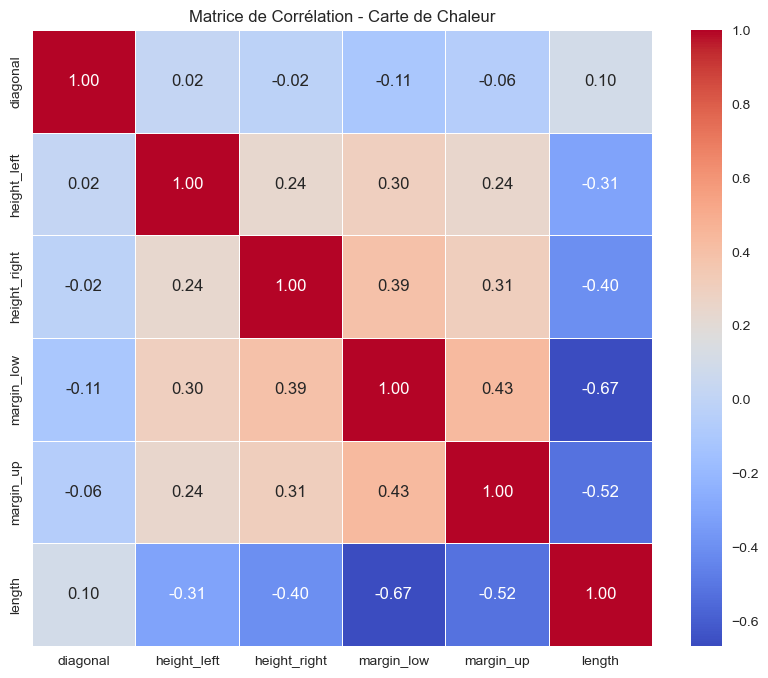

In [42]:
# Je calcule la matrice de corrélation entre les variables explicatives, en excluant la colonne 'is_genuine'
matrice_correlation_sans_authenticite = donnees_sans_valeurs_na.drop('is_genuine', axis=1).corr()

# Je vérifie la matrice de corrélation en l'affichant
print("Matrice de corrélation sans la colonne 'is_genuine':")
display(matrice_correlation_sans_authenticite)

# Je crée une nouvelle figure pour la carte de chaleur avec une taille spécifique
plt.figure(figsize=(10, 8))

# Je génère la carte de chaleur pour la matrice de corrélation
sns.heatmap(matrice_correlation_sans_authenticite, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)

# J'ajoute un titre à la carte de chaleur pour plus de clarté
plt.title("Matrice de Corrélation - Carte de Chaleur")

# Je montre la carte de chaleur
plt.show()


Je génère également une carte de chaleur pour visualiser ces relations de manière plus intuitive. Les valeurs de corrélation vont de -1 à 1. Une valeur proche de 1 indique une forte corrélation positive, tandis qu'une valeur proche de -1 indique une forte corrélation négative.

Modélisation à l'aide de la régression linéaire


Résumé statistique du modèle de régression linéaire :
                            OLS Regression Results                            
Dep. Variable:             margin_low   R-squared:                       0.477
Model:                            OLS   Adj. R-squared:                  0.476
Method:                 Least Squares   F-statistic:                     266.1
Date:                Sat, 16 Sep 2023   Prob (F-statistic):          2.60e-202
Time:                        10:48:41   Log-Likelihood:                -1001.3
No. Observations:                1463   AIC:                             2015.
Df Residuals:                    1457   BIC:                             2046.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------

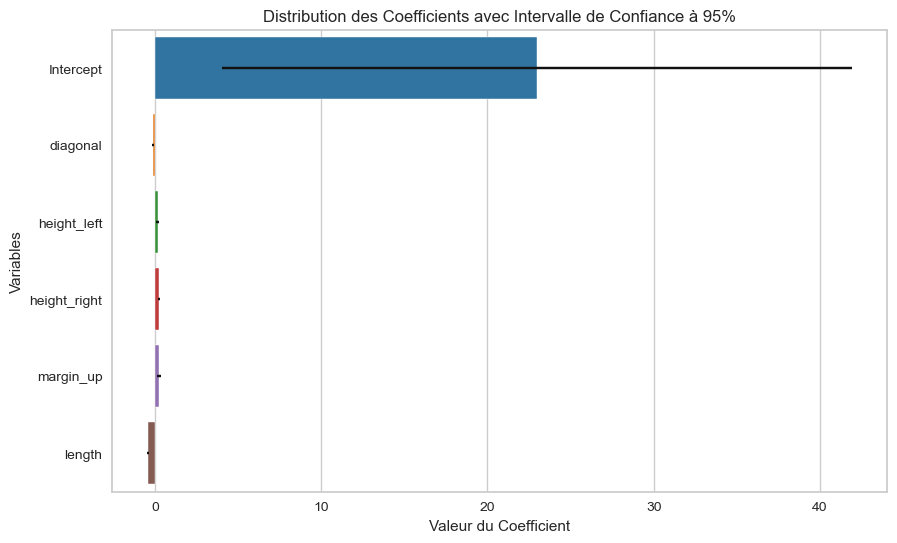

In [43]:
# Je réajuste le modèle de régression linéaire en utilisant les variables choisies
formule_regression = "margin_low ~ diagonal + height_left + height_right + margin_up + length"
modele_regression = smf.ols(formule_regression, data=donnees_sans_valeurs_na)
resultats_regression = modele_regression.fit()

# Je récupère un résumé statistique pour examiner les coefficients et leur significativité
resume_statistique = resultats_regression.summary()

# Je récupère les coefficients, les erreurs standard, et les intervalles de confiance pour chaque variable
coefficients = resultats_regression.params
erreur_standard = resultats_regression.bse
variables_modele = coefficients.index
intervalles_confiance = resultats_regression.conf_int()
intervalles_confiance.columns = ['Limite inférieure', 'Limite supérieure']

# Je crée un DataFrame pour conserver ces informations
df_resultats = pd.DataFrame({
    'Coefficient': coefficients,
    'Erreur standard': erreur_standard,
    'Limite inférieure': intervalles_confiance['Limite inférieure'],
    'Limite supérieure': intervalles_confiance['Limite supérieure'],
})

# Je visualise le résumé statistique
print("Résumé statistique du modèle de régression linéaire :")
print(resume_statistique)

# Je visualise les coefficients et leurs intervalles de confiance à 95%
palette_couleurs = sns.color_palette("tab10", len(variables_modele))
plt.figure(figsize=(10, 6))
sns.barplot(y=df_resultats.index, x='Coefficient', data=df_resultats, xerr=df_resultats['Erreur standard']*1.96, palette=palette_couleurs)
plt.xlabel('Valeur du Coefficient')
plt.ylabel('Variables')
plt.title('Distribution des Coefficients avec Intervalle de Confiance à 95%')
plt.grid(True, axis='x')
plt.show()


Après avoir ajusté le modèle, je génère un résumé statistique pour évaluer la performance et la significativité des coefficients. Ce résumé offre une vue complète des différentes métriques clés du modèle.Enfin, je visualise les coefficients et leurs intervalles de confiance à 95% pour une meilleure interprétation des résultats.

#### Les hypotheses de la regression linéaire

Calcul du Facteur d'Inflation de la Variance (VIF)


In [44]:
# Je récupère les variables indépendantes du modèle de régression ajusté
variables_independantes = resultats_regression.model.data.orig_exog

# Je calcule le Facteur d'Inflation de la Variance (VIF) pour chaque variable explicative
donnees_vif = pd.DataFrame()
donnees_vif['Variable'] = variables_independantes.columns
donnees_vif['VIF'] = [variance_inflation_factor(variables_independantes.values, i) for i in range(len(variables_independantes.columns))]

# Je vérifie les valeurs de VIF pour chaque variable
donnees_vif


,Variable,VIF
0,Intercept,590198.238883
1,diagonal,1.013613
2,height_left,1.138261
3,height_right,1.230115
4,margin_up,1.404404
5,length,1.576950


L'une des étapes cruciales dans la modélisation statistique est de vérifier la multicollinéarité entre les variables explicatives. Le Facteur d'Inflation de la Variance (VIF) est un indicateur couramment utilisé pour mesurer le degré de multicollinéarité.

Un VIF élevé pour une variable indique une forte corrélation avec les autres variables du modèle, ce qui pourrait rendre difficile l'interprétation des coefficients du modèle.

Visualisation des résidus du modèle


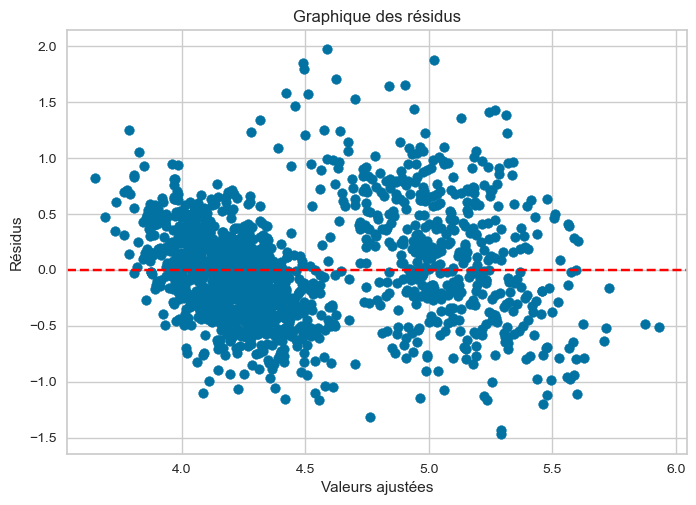

In [45]:
# Je récupère les résidus du modèle de régression ajusté
residus_modele = resultats_regression.resid

# Je récupère les valeurs ajustées produites par le modèle de régression
valeurs_ajustees_modele = resultats_regression.fittedvalues

# Je crée un graphique pour visualiser les résidus en fonction des valeurs ajustées
plt.scatter(valeurs_ajustees_modele, residus_modele)
plt.axhline(0, color='red', linestyle='--')  # Je trace une ligne horizontale à zéro pour référence
plt.xlabel('Valeurs ajustées')
plt.ylabel('Résidus')
plt.title('Graphique des résidus')

# Je montre le graphique
plt.show()



Je crée un graphique qui affiche les résidus en fonction des valeurs ajustées. Une dispersion aléatoire des points autour de la ligne horizontale à zéro indiquerait un bon ajustement du modèle.

Distribution des résidus


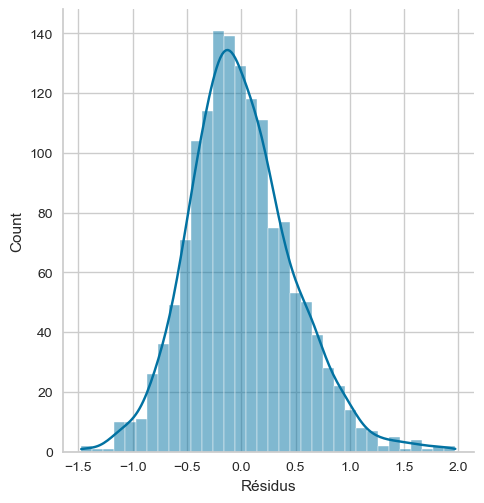

In [46]:
# Je crée un histogramme des résidus pour évaluer leur distribution
# L'ajout de l'estimation de la densité du noyau permet de mieux comprendre la forme de la distribution
sns.displot(residus_modele, kind='hist', kde=True)

# Je rajoute une étiquette à l'axe des x pour plus de clarté
plt.xlabel("Résidus")

# Je montre l'histogramme
plt.show()


L'histogramme et la courbe de densité nous aideront à vérifier si les résidus sont bien distribués autour de zéro et suivent une distribution normale, ce qui indiquerait un bon ajustement du modèle.



Comparaison des résidus et des valeurs prédites


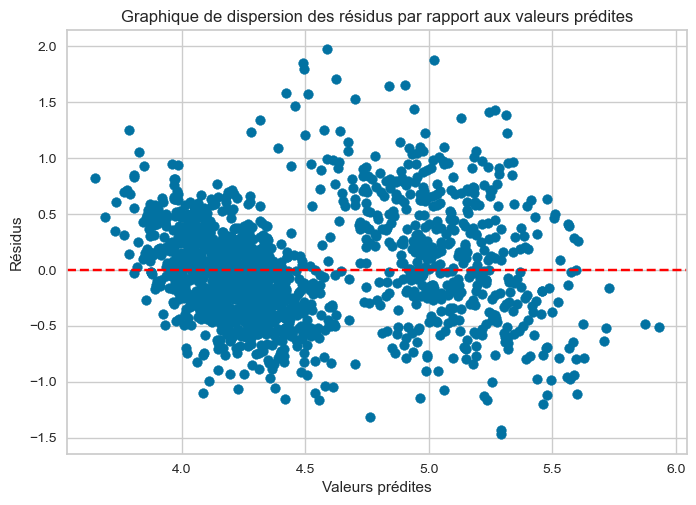

In [47]:
# Je crée un graphique de dispersion pour comparer les résidus aux valeurs prédites par le modèle
plt.scatter(valeurs_ajustees_modele, residus_modele)

# J'ajoute une ligne horizontale à zéro pour mieux visualiser la distribution des résidus
plt.axhline(0, color='red', linestyle='--')

# J'ajoute des étiquettes et un titre pour améliorer la lisibilité du graphique
plt.xlabel('Valeurs prédites')
plt.ylabel('Résidus')
plt.title('Graphique de dispersion des résidus par rapport aux valeurs prédites')

# Je montre le graphique
plt.show()



 Ce graphique nous permet de vérifier si les résidus sont distribués de manière aléatoire autour de la ligne horizontale à zéro, ce qui serait un bon indicateur de la qualité de l'ajustement du modèle.

Évaluation de la normalité des résidus avec un QQ-Plot


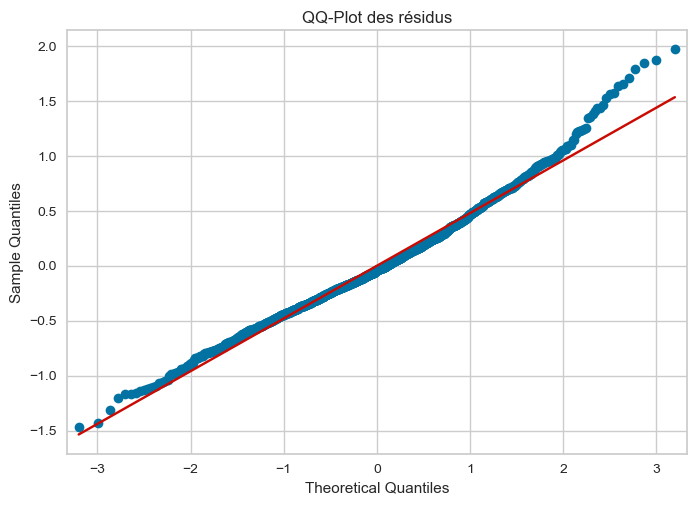

In [48]:
# J'importe la bibliothèque statsmodels pour créer le QQ-Plot
import statsmodels.api as sm

# Je génère un QQ-Plot pour évaluer si les résidus suivent une distribution normale
# La ligne 's' (standard) représente une distribution normale standard
sm.qqplot(residus_modele, line='s')

# J'ajoute un titre au QQ-Plot pour plus de clarté
plt.title('QQ-Plot des résidus')

# J'affiche le QQ-Plot
plt.show()


Si les points du QQ-Plot suivent la ligne droite ('s'), cela indique que les résidus sont bien distribués selon une distribution normale, ce qui est une hypothèse importante en régression linéaire.

Test de Shapiro-Wilk pour la normalité des résidus


In [49]:
from scipy.stats import shapiro

# J'utilise le test de Shapiro-Wilk pour vérifier la normalité des résidus
# Ce test retourne une statistique et une valeur p
statistique, valeur_p = shapiro(residus_modele)
print('Statistique = %.3f, valeur p = %.3f' % (statistique, valeur_p))

# J'interprète le résultat du test
# Si la valeur p est supérieure à 0.05, l'hypothèse de normalité n'est pas rejetée
if valeur_p > 0.05:
    print('Probablement normal')
else:
    print('Probablement pas normal')


Statistique = 0.986, valeur p = 0.000
Probablement pas normal


Le test retourne une statistique et une valeur 
�
p. Si la valeur 
�
p est supérieure à 0.05, l'hypothèse de normalité des résidus n'est pas rejetée, ce qui est bon pour la validité du modèle.

Vérification de l'homoscédasticité des résidus


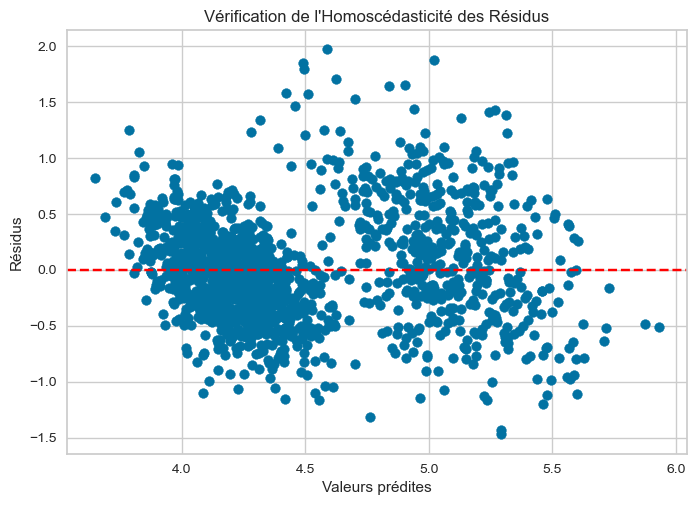

In [50]:
# Je crée un graphique de dispersion pour évaluer l'homoscédasticité des résidus
plt.scatter(valeurs_ajustees_modele, residus_modele)
plt.axhline(0, color='red', linestyle='--')  # J'ajoute une ligne horizontale à zéro pour référence
plt.xlabel('Valeurs prédites')
plt.ylabel('Résidus')
plt.title('Vérification de l\'Homoscédasticité des Résidus')

# J'affiche le graphique
plt.show()


Une distribution aléatoire et constante des résidus autour de la ligne horizontale à zéro serait un bon indicateur de l'homoscédasticité des résidus.

Tests statistiques pour l'homoscédasticité des résidus


In [51]:
from statsmodels.compat import lzip
import statsmodels.stats.api as sms
import statsmodels.api as sm
from statsmodels.formula.api import ols

# Je réalise le test de Breusch-Pagan pour évaluer l'homoscédasticité des résidus
noms_tests_bp = ['Statistique du multiplicateur de Lagrange', 'Valeur p', 'Valeur f', 'Valeur p de f']
resultats_test_bp = sms.het_breuschpagan(residus_modele, resultats_regression.model.exog)
print("Résultats du test de Breusch-Pagan:")
for nom, valeur in zip(noms_tests_bp, resultats_test_bp):
    print(f"{nom}: {valeur}")

# Je réalise le test de Goldfeld-Quandt pour évaluer l'homoscédasticité des résidus
noms_tests_gq = ['Valeur F', 'Valeur p']
resultats_test_gq = sm.stats.diagnostic.het_goldfeldquandt(residus_modele, resultats_regression.model.exog)
print("\nRésultats du test de Goldfeld-Quandt:")
for nom, valeur in zip(noms_tests_gq, resultats_test_gq[:2]):
    print(f"{nom}: {valeur}")

# J'interprète les résultats des tests
# Une valeur p faible (< 0.05) indique que les résidus sont probablement hétéroscédastiques
if resultats_test_bp[1] < 0.05 or resultats_test_gq[1] < 0.05:
    print("\nLes résidus sont probablement hétéroscédastiques.")
else:
    print("\nLes résidus sont probablement homoscédastiques.")


Résultats du test de Breusch-Pagan:
Statistique du multiplicateur de Lagrange: 80.16261280175056
Valeur p: 7.759535216194938e-16
Valeur f: 16.89235884615347
Valeur p de f: 2.9227496566219426e-16

Résultats du test de Goldfeld-Quandt:
Valeur F: 3.126447221570459
Valeur p: 6.624886644466403e-51

Les résidus sont probablement hétéroscédastiques.


 J'utilise deux tests différents pour cette vérification : le test de Breusch-Pagan et le test de Goldfeld-Quandt.

Le test de Breusch-Pagan examine si les résidus quadratiques sont corrélés aux variables explicatives.
Le test de Goldfeld-Quandt divise les données en deux groupes et compare les variances des résidus entre les deux.
Une valeur p faible (< 0.05) dans l'un de ces tests indiquerait que les résidus sont probablement hétéroscédastiques, ce qui serait un problème pour la validité du modèle.

En conséquence, étant donné que la p-valeur est très proche de zéro, on peut rejeter l'hypothèse nulle d'homoskédasticité. Cela suggère que les résidus du modèle de régression linéaire ont une variance qui n'est pas constante, ce qui peut indiquer une hétéroscédasticité dans les résidus. En d'autres termes, les erreurs du modèle peuvent présenter des variations inégales autour de la droite de régression, ce qui peut avoir un impact sur les propriétés statistiques et les conclusions du modèle.

Prédiction avec le modèle existant et remplacement des valeurs manquantes par des prédictions


In [52]:


# 1. J'identifie les données manquantes dans la colonne 'margin_low'
donnees_manquantes = donnees_billets[donnees_billets['margin_low'].isnull()]

# 2. J'effectue des prédictions pour ces valeurs manquantes
# Je m'assure que donnees_manquantes contient toutes les colonnes nécessaires pour la prédiction
valeurs_manquantes_predites = resultats_regression.predict(donnees_manquantes)

# 3. Je remplace les valeurs manquantes dans le DataFrame original par les valeurs prédites
donnees_billets.loc[donnees_billets['margin_low'].isnull(), 'margin_low'] = valeurs_manquantes_predites

# 4. Je vérifie si toutes les valeurs manquantes ont été comblées
print(donnees_billets.isnull().sum())


is_genuine      0
diagonal        0
height_left     0
height_right    0
margin_low      0
margin_up       0
length          0
dtype: int64


Copy des resultats du model

In [53]:
# Je crée une copie du DataFrame original pour travailler sur une version indépendante des données
df = donnees_billets.copy()
df.to_csv('df_model_reg.csv', index=False)


In [54]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   is_genuine    1500 non-null   bool   
 1   diagonal      1500 non-null   float64
 2   height_left   1500 non-null   float64
 3   height_right  1500 non-null   float64
 4   margin_low    1500 non-null   float64
 5   margin_up     1500 non-null   float64
 6   length        1500 non-null   float64
dtypes: bool(1), float64(6)
memory usage: 71.9 KB


Analyse univariée des variables


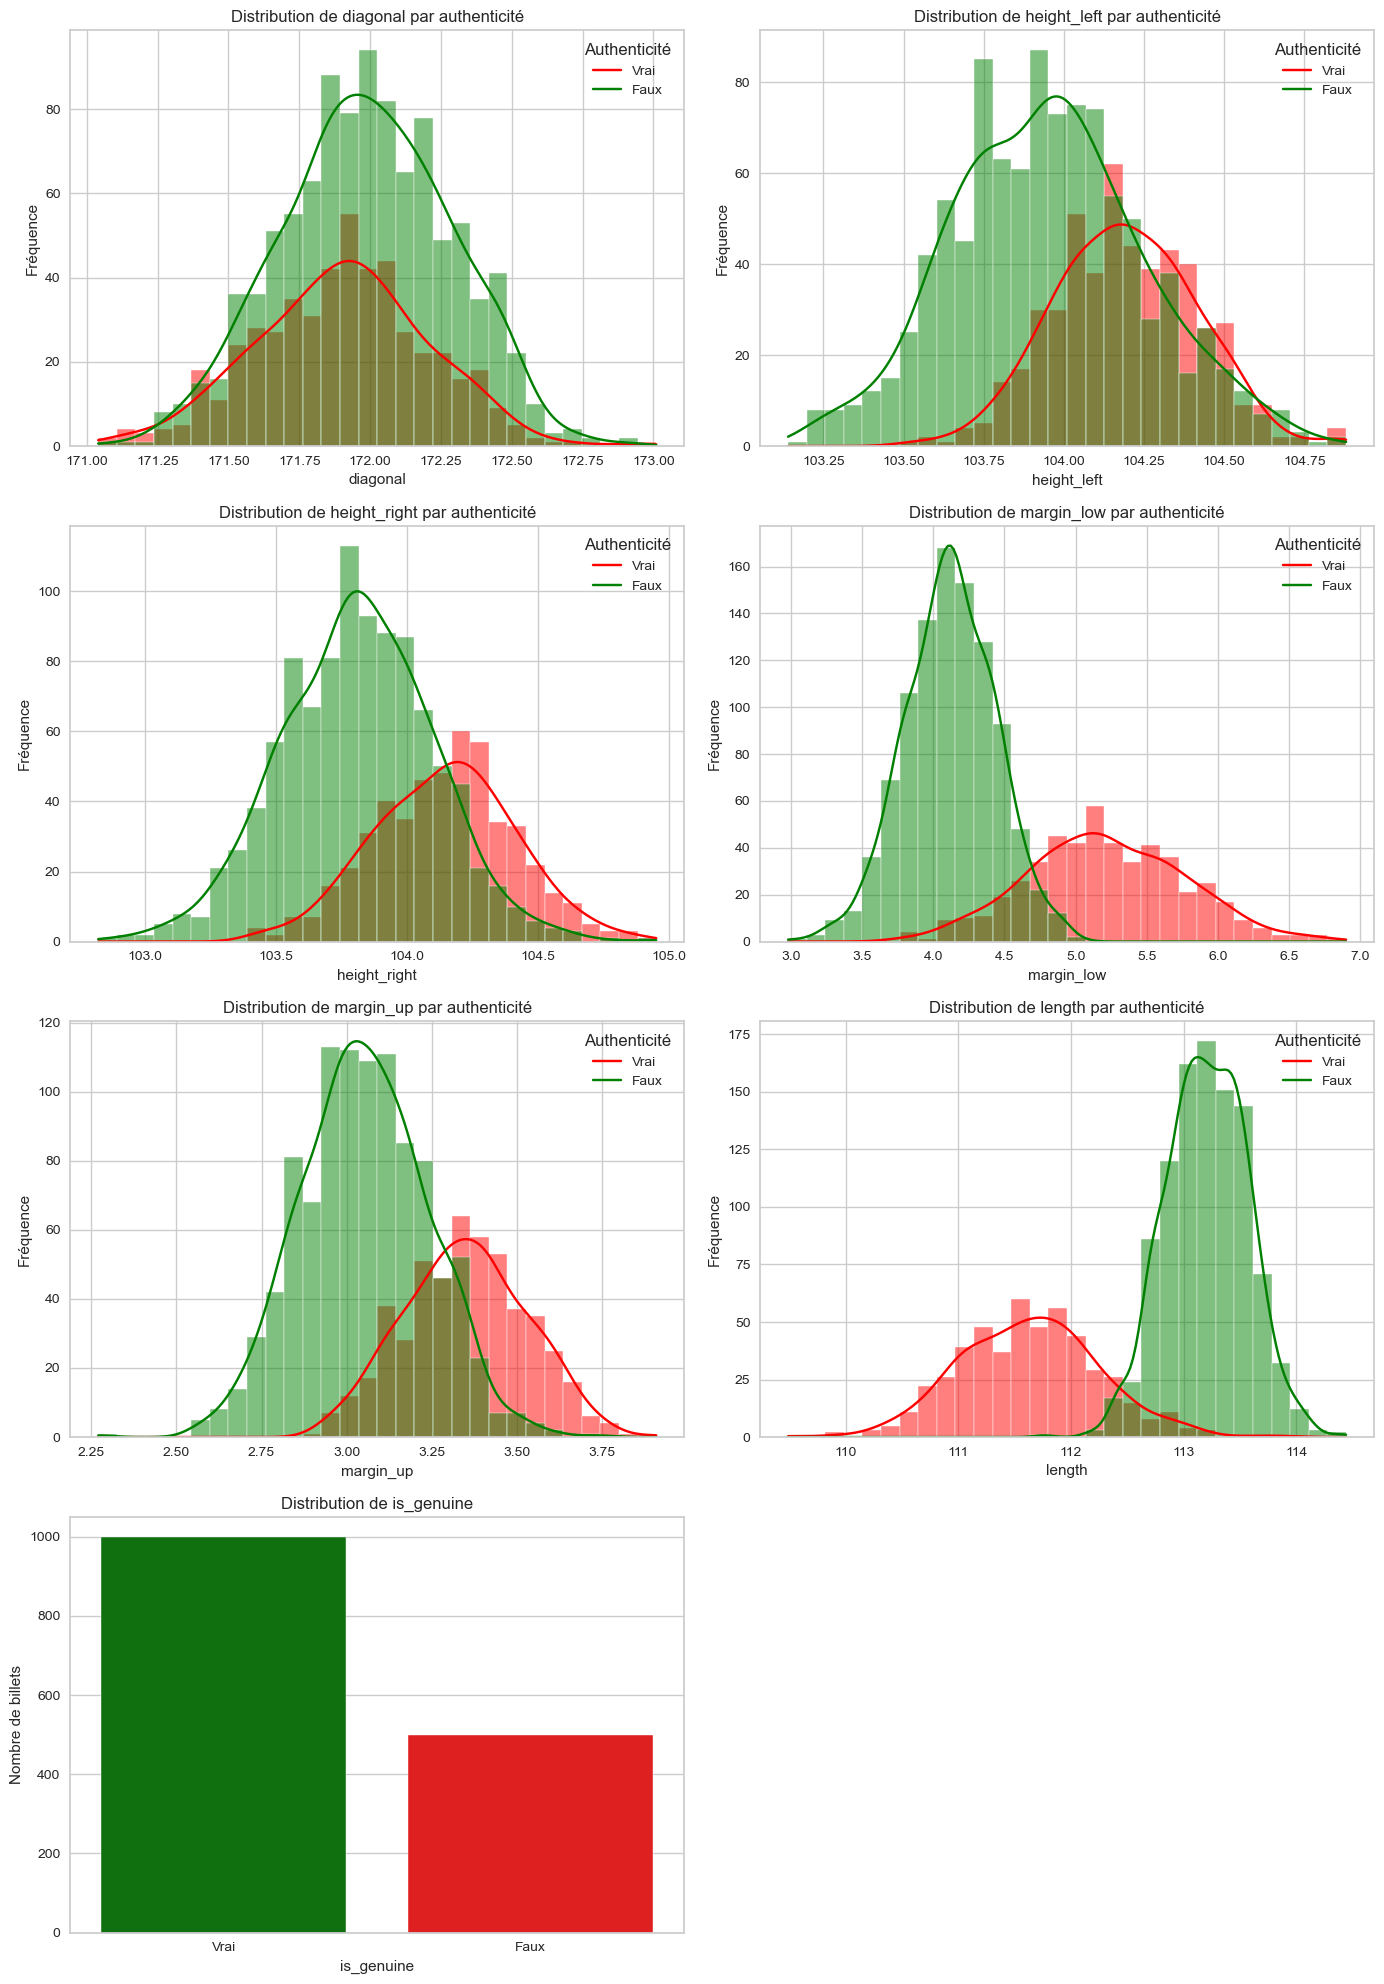

In [55]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Je configure le style des graphiques pour une meilleure lisibilité
sns.set_style("whitegrid")

# Je crée des sous-graphiques pour analyser univariément chaque colonne
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(14, 20))

# Je définis la palette de couleurs et l'ordre des étiquettes
palette = {0: 'red', 1: 'green'}
hue_order = [1, 0]

# Je génère des histogrammes pour les variables continues
colonnes = ['diagonal', 'height_left', 'height_right', 'margin_low', 'margin_up', 'length']
for i, col in enumerate(colonnes):
    ax = axes[i//2, i%2]
    sns.histplot(df, x=col, hue='is_genuine', kde=True, ax=ax, bins=30, palette=palette, hue_order=hue_order)
    ax.set_title(f'Distribution de {col} par authenticité')
    ax.set_xlabel(col)
    ax.set_ylabel('Fréquence')
    ax.legend(title='Authenticité', labels=['Vrai', 'Faux'])

# Je crée un diagramme en barres pour la variable catégorielle 'is_genuine'
sns.countplot(data=df, x='is_genuine', ax=axes[3, 0], palette=palette, order=hue_order)
axes[3, 0].set_title('Distribution de is_genuine')
axes[3, 0].set_xlabel('is_genuine')
axes[3, 0].set_ylabel('Nombre de billets')
axes[3, 0].set_xticklabels(['Vrai', 'Faux'])

# Je supprime le graphique vide pour une meilleure présentation
axes[3, 1].axis('off')

# J'ajuste l'agencement pour éviter les superpositions
plt.tight_layout()

# J'affiche tous les graphiques
plt.show()


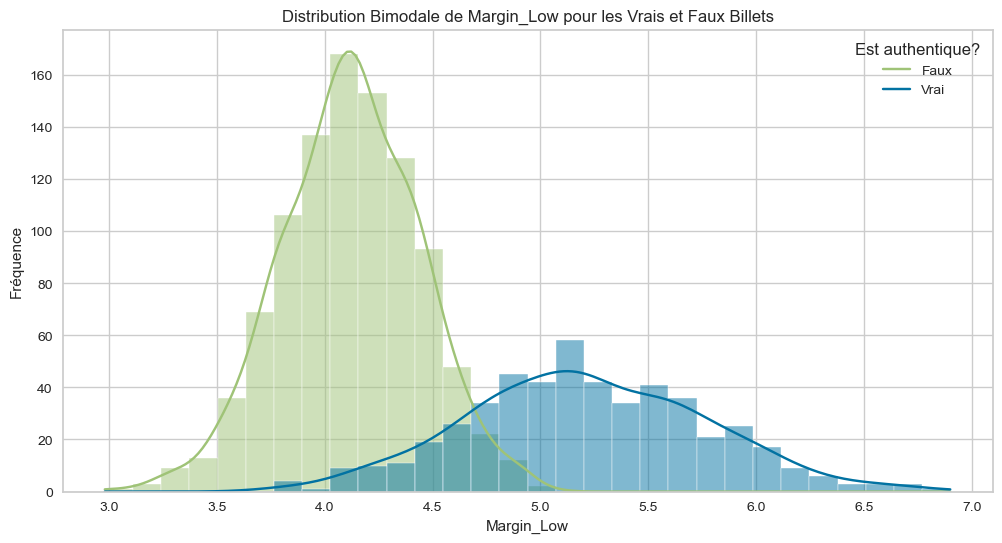

In [56]:
# Creating a bimodal distribution for 'margin_low' to distinguish between genuine and fake notes
plt.figure(figsize=(12, 6))
sns.histplot(df, x='margin_low', hue='is_genuine', kde=True, bins=30)
plt.title('Distribution Bimodale de Margin_Low pour les Vrais et Faux Billets')
plt.xlabel('Margin_Low')
plt.ylabel('Fréquence')
plt.legend(title='Est authentique?', labels=['Faux', 'Vrai'])
plt.show()


Pour les variables continues, je crée des histogrammes qui montrent la distribution des valeurs pour les billets authentiques et les faux billets.
Pour la variable catégorielle is_genuine, je crée un diagramme en barres qui indique le nombre de billets authentiques et de faux billets.

Analyse bivariée des variables


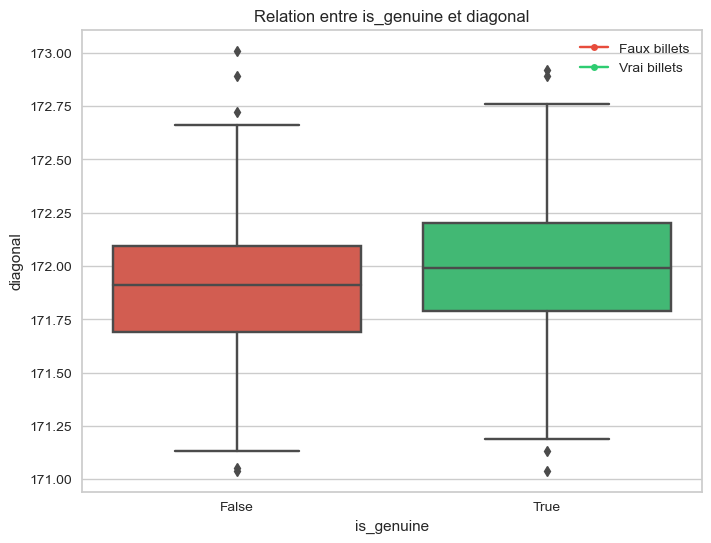

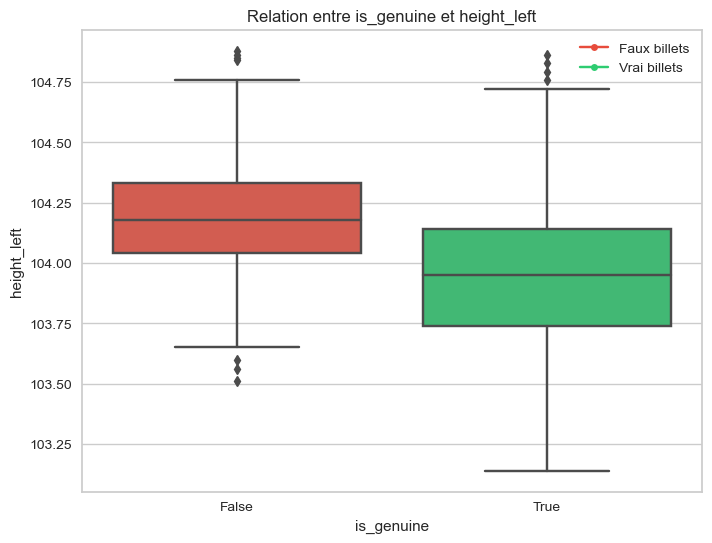

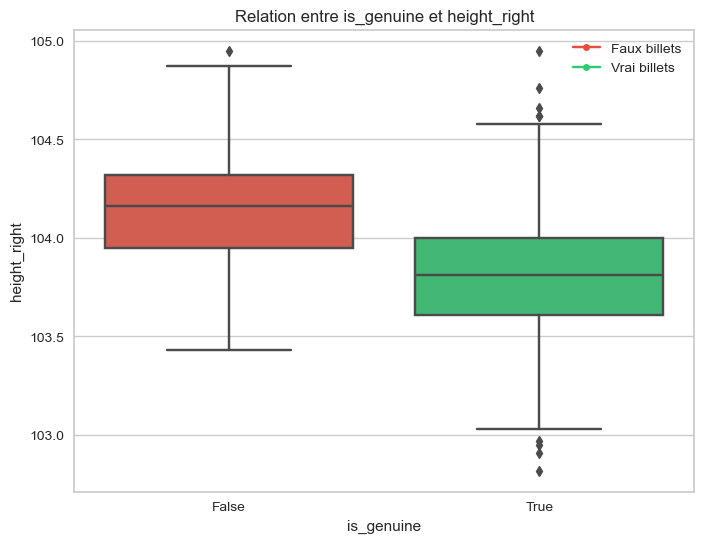

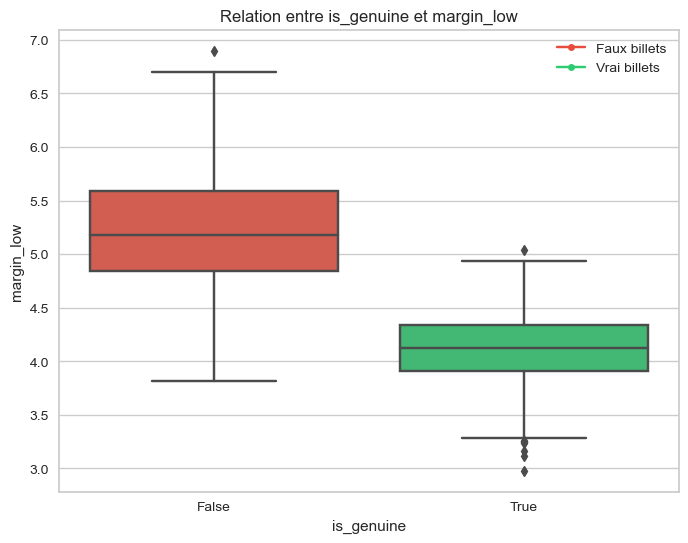

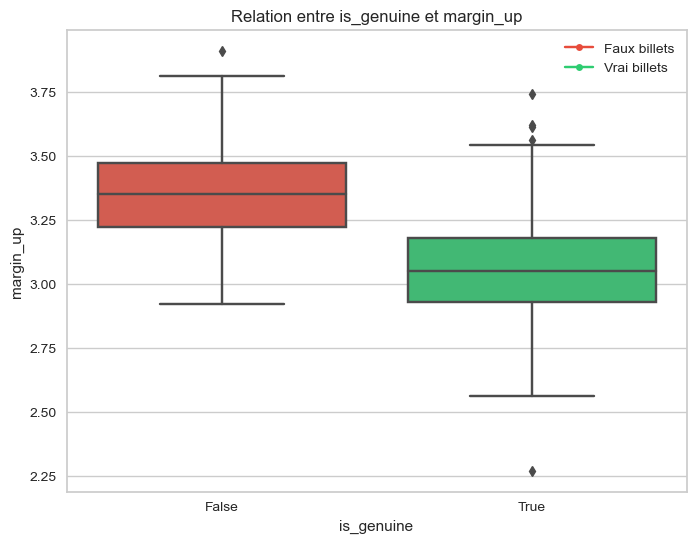

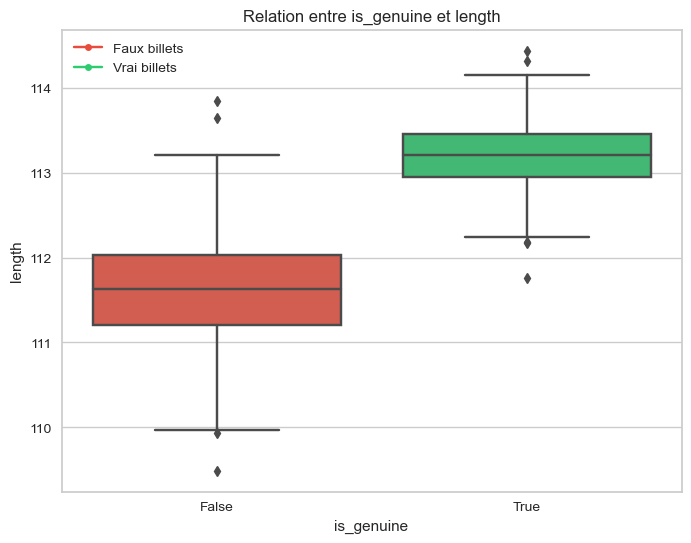

In [57]:
from matplotlib.lines import Line2D  
columns = ['diagonal', 'height_left', 'height_right', 'margin_low', 'margin_up', 'length']

# Je réalise une analyse bivariée pour étudier les relations entre les variables et l'authenticité des billets
labels = ['Faux billets', 'Vrai billets']
palette = ['#e74c3c', '#2ecc71']

for i, col in enumerate(columns):
    plt.figure(figsize=(8, 6))
    sns.boxplot(data=df, x='is_genuine', y=col, palette=palette)
    plt.title(f'Relation entre is_genuine et {col}')
    plt.xlabel('is_genuine')
    plt.ylabel(col)
    
    # Je crée une légende personnalisée
    handles = [Line2D([], [], color=palette[j], marker='o', markersize=5, label=labels[j]) for j in range(2)]
    
    plt.legend(handles=handles)
    plt.show()


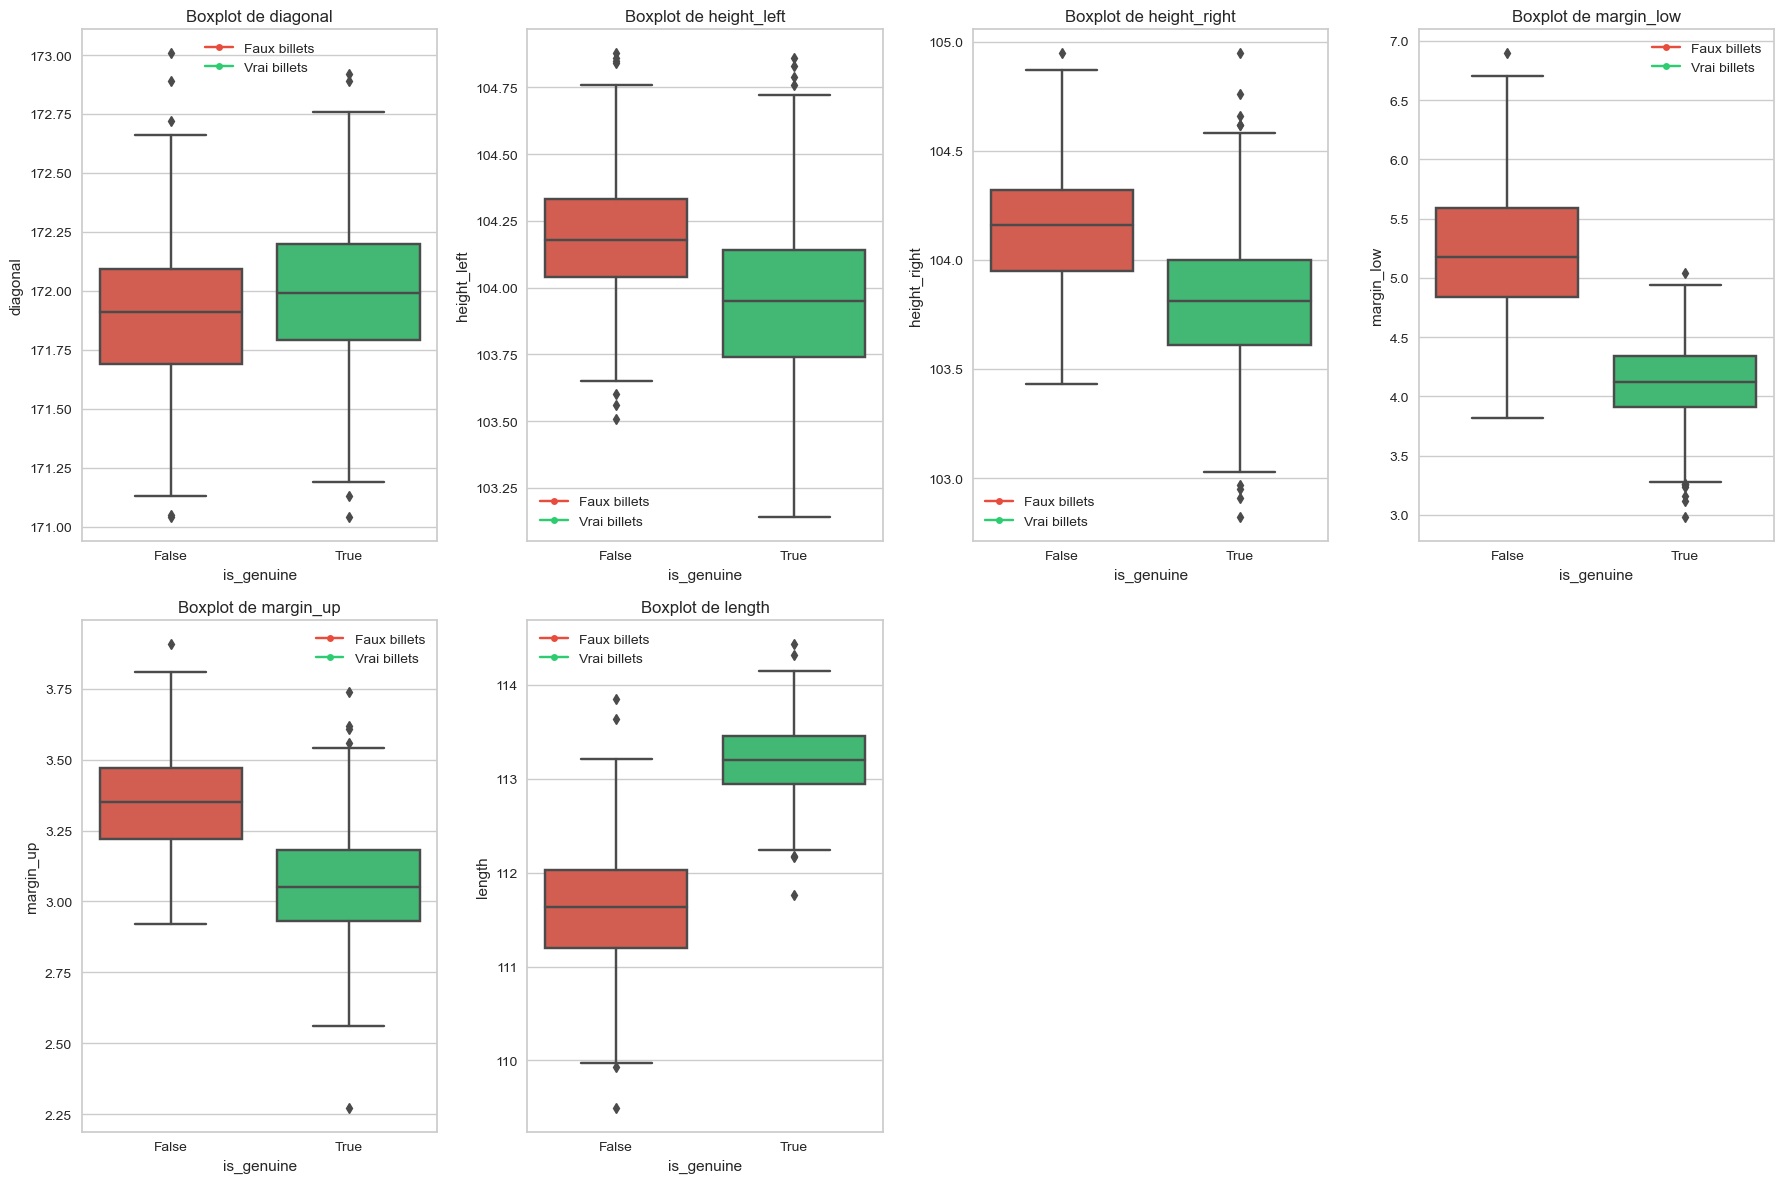

In [58]:
# Creating boxplots to compare genuine and fake notes for each variable
plt.figure(figsize=(18, 12))

# List of numerical columns to plot
num_columns = ['diagonal', 'height_left', 'height_right', 'margin_low', 'margin_up', 'length']
labels = ['Faux billets', 'Vrai billets']
palette = ['#e74c3c', '#2ecc71']
for i, column in enumerate(num_columns, 1):
    plt.subplot(2, 4, i)
    sns.boxplot(x='is_genuine', y=column, data=df,palette=palette)
    plt.title(f'Boxplot de {column}')
   #Je crée une légende personnalisée
    handles = [Line2D([], [], color=palette[j], marker='o', markersize=5, label=labels[j]) for j in range(2)]
    
    plt.legend(handles=handles)
plt.tight_layout()
plt.show()


Matrice de corrélation des variables


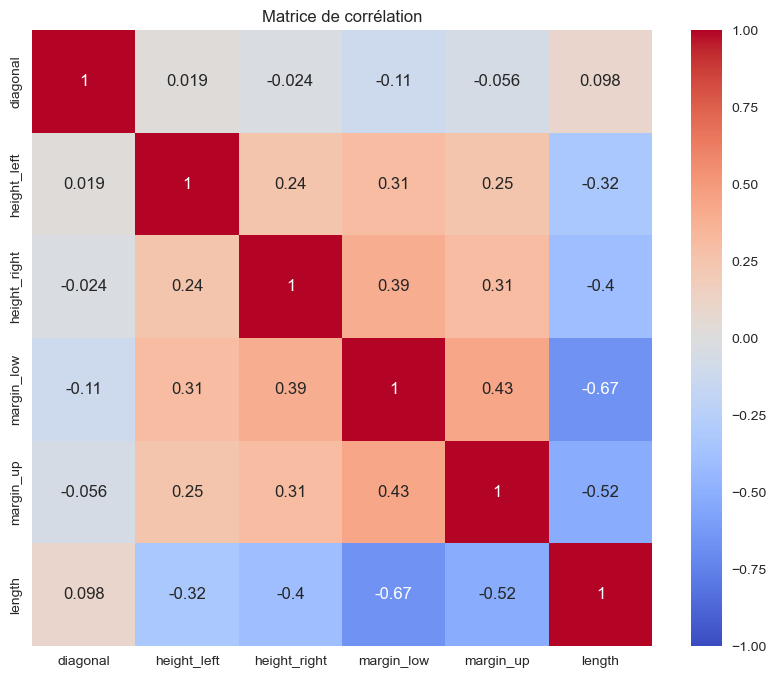

In [59]:
# Je calcule la matrice de corrélation pour les colonnes spécifiées
correlation_matrix = df[columns].corr()

# Je visualise la matrice de corrélation avec une carte de chaleur (heatmap)
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)

# Je définis le titre de la carte de chaleur
plt.title('Matrice de corrélation')

# Je montre le graphique
plt.show()


In [60]:
correlation_matrix = df.corr()
display(correlation_matrix)


,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
is_genuine,1.000000,0.132756,-0.379833,-0.485092,-0.783448,-0.606262,0.849285
diagonal,0.132756,1.000000,0.019472,-0.024492,-0.110697,-0.055649,0.097587
height_left,-0.379833,0.019472,1.000000,0.242279,0.309209,0.246522,-0.320863
height_right,-0.485092,-0.024492,0.242279,1.000000,0.393541,0.307005,-0.401751
margin_low,-0.783448,-0.110697,0.309209,0.393541,1.000000,0.434237,-0.670966
margin_up,-0.606262,-0.055649,0.246522,0.307005,0.434237,1.000000,-0.520575
length,0.849285,0.097587,-0.320863,-0.401751,-0.670966,-0.520575,1.000000


In [61]:
df['is_genuine'] = df['is_genuine'].astype(int)


s_genuine et length : Avec une corrélation de 0.849, cela indique une forte relation positive entre la longueur du billet et le fait qu'il soit authentique.<br><br>
is_genuine et margin_low : La corrélation de -0.785 signifie une forte relation négative entre la marge inférieure du billet et le fait qu'il soit authentique.<br><br>
is_genuine et margin_up : La corrélation de -0.606 montre une relation négative modérée entre la marge supérieure du billet et le fait qu'il soit authentique.<br><br>

Analyse en composantes principales (ACP)


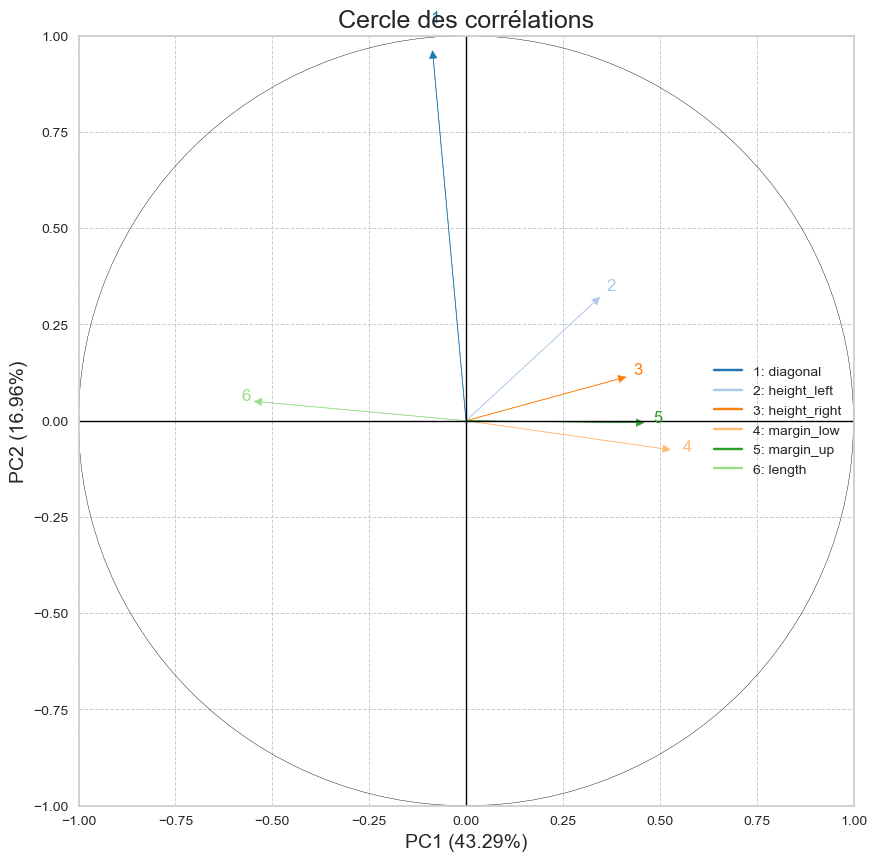

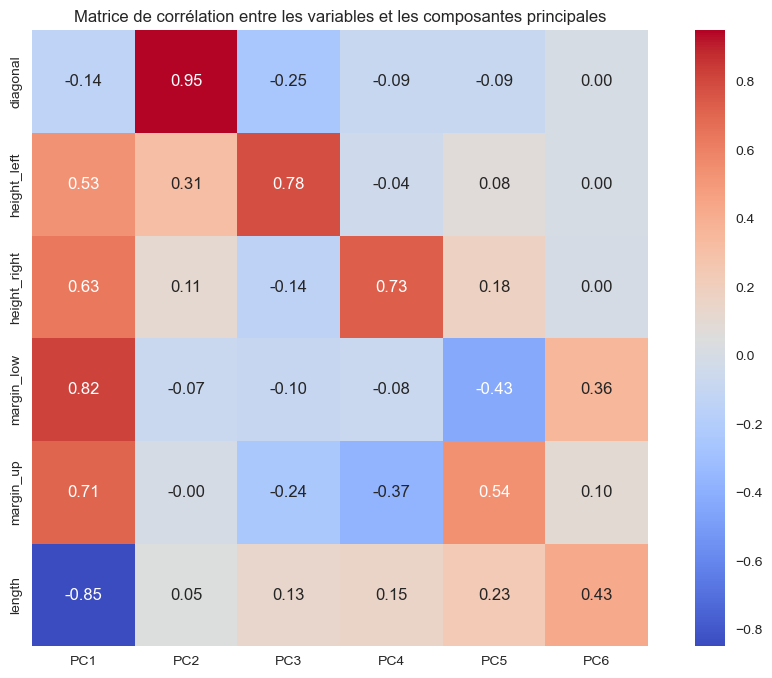

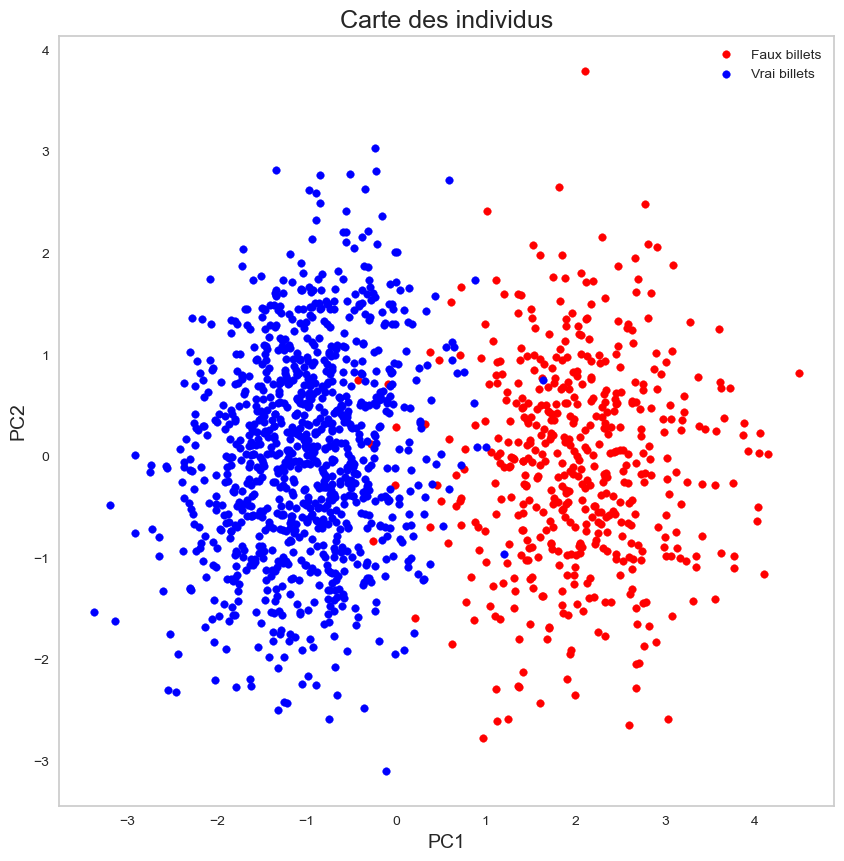

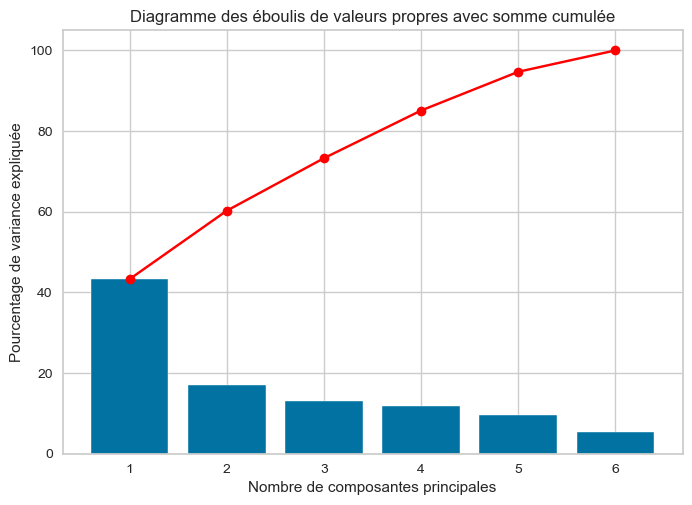

In [62]:
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.lines as mlines
# Je prépare la cible
target = df['is_genuine']
# Sélectionner uniquement les variables quantitatives pour l'ACP
data_acp = df.drop('is_genuine', axis=1)

# Normaliser les données
scaler = StandardScaler()
data_normalized = scaler.fit_transform(data_acp)

# Je initialise PCA
pca = PCA()
principalComponents = pca.fit_transform(data_normalized)

df_pca = pd.DataFrame(principalComponents, columns=['PC'+str(i) for i in range(1, len(data_acp.columns)+1)])

# Je concatène le dataframe des composantes principales avec le dataframe de la cible
finalDf = pd.concat([df_pca, target], axis = 1)

explained_var_ratio = pca.explained_variance_ratio_

# Ici, je définis la palette de couleurs pour le cercle des corrélations.
palette = plt.get_cmap('tab20')

# Ensuite, je dessine le cercle des corrélations.
fig, ax = plt.subplots(figsize=(10,10))
# Affichage des pourcentages de variance
plt.xlabel(f'PC1 ({explained_var_ratio[0]*100:.2f}%)', fontsize=14)
plt.ylabel(f'PC2 ({explained_var_ratio[1]*100:.2f}%)', fontsize=14)
# Ici, j'affiche les lignes du cercle de corrélation.
lines = []  # Pour stocker les lignes de la légende
for i in range(len(pca.components_[0])):
    ax.arrow(0, 0, pca.components_[0, i], pca.components_[1, i], head_width=0.02, head_length=0.02, color=palette(i))
    # J'ajoute le numéro à la flèche avec un léger décalage pour l'éloigner de la flèche.
    ax.text(pca.components_[0, i]*1.1, pca.components_[1, i]*1.1, str(i+1), color=palette(i), fontsize=12, ha='left')
    line = mlines.Line2D([], [], color=palette(i), markersize=15, label='{}: {}'.format(i+1, data_acp.columns[i]))  # Je crée la ligne pour la légende.
    lines.append(line)

# J'affiche le cercle.
circle = plt.Circle((0,0), 1, color='black', fill=False)
ax.add_artist(circle)
# Ajout d'un quadrillage plus détaillé
plt.grid(True, which='both', linestyle='--', linewidth=0.7)

# Ajout des lignes d'axe
plt.axhline(0, color='black', linewidth=1)
plt.axvline(0, color='black', linewidth=1)

# J'ajuste l'apparence du graphique.
plt.title('Cercle des corrélations', fontsize=18)
# Pourcentage de variance expliquée

plt.title('Cercle des corrélations', fontsize=18)
# J'ajoute la légende.
ax.legend(handles=lines, loc='best')
plt.xlim(-1, 1)
plt.ylim(-1, 1)

# J'affiche le graphique.
plt.show()
# Calcul de la matrice de corrélation entre les variables et les composantes principales
all_data = pd.concat([data_acp.reset_index(drop=True), df_pca.reset_index(drop=True)], axis=1)
correlation_matrix = all_data.corr()

# Sélection de la matrice de corrélation entre les variables originales et les composantes principales
corr_with_pca = correlation_matrix.loc[data_acp.columns, ['PC'+str(i) for i in range(1, len(data_acp.columns)+1)]]

# Affichage de la heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_with_pca, annot=True, cmap='coolwarm', cbar=True, square=True, fmt='.2f', annot_kws={'size': 12})
plt.title('Matrice de corrélation entre les variables et les composantes principales')
plt.show()

fig, ax = plt.subplots(figsize=(10, 10))
targets = [0, 1]
colors = ['red', 'blue']
labels = ['Faux billets', 'Vrai billets']  # Étiquettes pour la légende

scatter_objects = []  # Liste pour stocker les objets scatter

for target, color, label in zip(targets, colors, labels):
    indicesToKeep = finalDf['is_genuine'] == target
    scatter = ax.scatter(finalDf.loc[indicesToKeep, 'PC1'],
                         finalDf.loc[indicesToKeep, 'PC2'],
                         c=color, s=30)  # Création de l'objet scatter
    scatter_objects.append(scatter)  # Ajout de l'objet scatter à la liste

# J'ajuste l'apparence du graphique.
plt.title('Carte des individus', fontsize=18)
plt.xlabel('PC1', fontsize=14)
plt.ylabel('PC2', fontsize=14)
plt.grid()

# Création de la légende en utilisant les objets scatter stockés dans la liste
plt.legend(scatter_objects, labels)

# J'affiche le graphique.
plt.show()




# Ici, je calcule la distance de chaque point à l'origine.
df_pca['distance'] = np.sqrt(df_pca['PC1']**2 + df_pca['PC2']**2)

# Je définis un seuil pour considérer un point comme un outlier.
seuil = df_pca['distance'].quantile(0.95)  # par exemple, tous les points au-delà du 95ème percentile

# Je trouve les outliers.
outliers = df_pca[df_pca['distance'] > seuil]


# Je crée une fonction pour afficher le diagramme d'éboulis.
def afficher_diagramme_eboulis(pca):
    eboulis = pca.explained_variance_ratio_ * 100
    plt.bar(np.arange(len(eboulis)) + 1, eboulis)
    plt.plot(np.arange(len(eboulis)) + 1, eboulis.cumsum(), c="red", marker='o')
    plt.xlabel("Nombre de composantes principales")
    plt.ylabel("Pourcentage de variance expliquée")
    plt.title("Diagramme des éboulis de valeurs propres avec somme cumulée")
    plt.show(block=False)



# Appel des fonctions pour afficher les graphiques.
afficher_diagramme_eboulis(pca)



Table de correspondance composantes et variables

In [63]:
# Conversion de la matrice de corrélation en DataFrame Pandas (si nécessaire)
corr_with_pca_df = pd.DataFrame(corr_with_pca)

# Affichage du DataFrame
print("Tableau de correspondance entre les composantes principales et les variables originales :")
print(corr_with_pca_df)


Tableau de correspondance entre les composantes principales et les variables originales :
                   PC1       PC2       PC3       PC4       PC5       PC6
diagonal     -0.136500  0.949456 -0.254461 -0.085883 -0.088044  0.004705
height_left   0.532855  0.310192  0.782407 -0.041479  0.077159  0.003458
height_right  0.634259  0.109270 -0.144594  0.729917  0.179135  0.000615
margin_low    0.818204 -0.073067 -0.096400 -0.075194 -0.428173  0.356264
margin_up     0.708166 -0.004997 -0.238786 -0.374027  0.540437  0.097412
length       -0.849404  0.049057  0.131808  0.148551  0.234443  0.426265


Segmentation(Kmeans),Score silouette,Centroides des clusters

c:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\ProgramData\Anaconda3\lib\site-packages\sklearn\clust

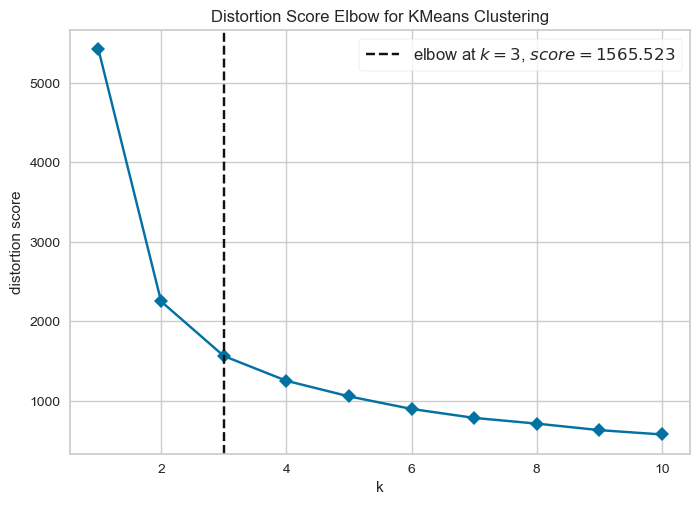

c:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


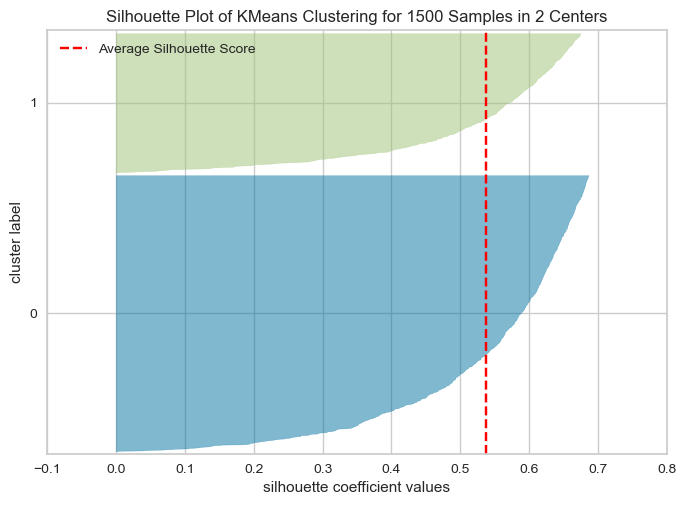

c:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


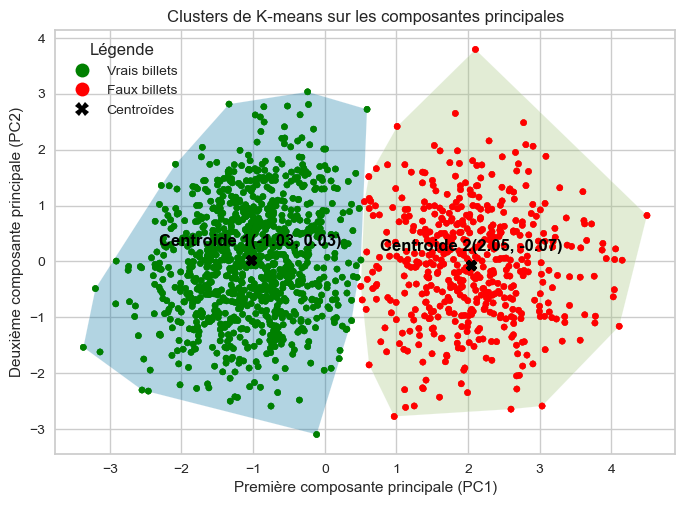

Coordonnées des centroides :


,PC1,PC2
0,-1.032051,0.033634
1,2.045635,-0.066667


Répartition des vrais et faux billets pour 2 clusters :


is_genuine,0,1
row_0,,
0,12,985
1,488,15


c:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Répartition des vrais et faux billets pour 3 clusters :


is_genuine,0,1
row_0,,
0,5,514
1,484,11
2,11,475


In [64]:
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from scipy.spatial import ConvexHull
from sklearn.decomposition import PCA

# Prendre seulement les deux premières composantes principales pour le clustering K-means
X_pca = df_pca[['PC1', 'PC2']].values  

# Utilisation de Yellowbrick pour générer le graphique du coude
model = KMeans()
visualizer = KElbowVisualizer(model, k=(1, 11), timings=False)
visualizer.fit(X_pca)
visualizer.set_title("Diagramme du coude pour le nombre optimal de clusters")
visualizer.show()

# le nombre optimal de clusters est 2
n_clusters = 2

# Utilisation de Yellowbrick pour le score silhouette
model = KMeans(n_clusters=n_clusters)
visualizer = SilhouetteVisualizer(model, colors='yellowbrick')
visualizer.fit(X_pca)
visualizer.set_title("Score Silhouette pour K-means avec k = {}".format(n_clusters))
visualizer.show()

# Entraînement du modèle K-means
kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(X_pca)
labels = kmeans.labels_


# Trouver les vrais et faux billets
colors = ['green' if label == 0 else 'red' for label in labels]


# Visualisation des clusters
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=colors, s=20)  # Réduction de la taille des points à 20
centroid_scatter = plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], marker='X', s=50, linewidths=1, color='black', zorder=10)  # Réduction de la taille et de l'épaisseur du marqueur X

# Forme autour des clusters
unique_clusters = np.unique(labels)  # Identifiants uniques des clusters
for i in unique_clusters:
    points = X_pca[labels == i]  # Points appartenant au cluster i
    hull = ConvexHull(points)
    x_hull = np.append(points[hull.vertices, 0], points[hull.vertices, 0][0])
    y_hull = np.append(points[hull.vertices, 1], points[hull.vertices, 1][0])
    plt.fill(x_hull, y_hull, alpha=0.3)  # Vous pouvez choisir votre propre niveau d'alpha et d'autres propriétés

# Visualisation des clusters
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=colors, s=20)
centroid_scatter = plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], marker='X', s=50, linewidths=1, color='black', zorder=10)

# Création de légendes personnalisées
legend_elements = [Line2D([0], [0], marker='o', color='w', markerfacecolor='green', markersize=10, label='Vrais billets'),
                   Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='Faux billets'),
                   Line2D([0], [0], marker='X', color='w', markerfacecolor='black', markersize=10, label='Centroïdes')]

plt.title("Clusters de K-means sur les composantes principales")
plt.xlabel("Première composante principale (PC1)")
plt.ylabel("Deuxième composante principale (PC2)")
plt.legend(handles=legend_elements, title="Légende")
# Annotation pour les coordonnées des centroides
for i, (x, y) in enumerate(kmeans.cluster_centers_):
    plt.annotate(f'Centroide {i+1}({x:.2f}, {y:.2f})', (x, y), textcoords="offset points", xytext=(0, 10), ha='center',color='black',fontweight='bold')
plt.show()


# Création et affichage d'un DataFrame pour les coordonnées des centroides
centroid_df = pd.DataFrame(kmeans.cluster_centers_, columns=['PC1', 'PC2'])
print("Coordonnées des centroides :")
display(centroid_df)

# Nombre de vrais et de faux billets dans chaque cluster pour 2 et 3 clusters
cross_tab_2_clusters = pd.crosstab(labels, df['is_genuine'])
print("Répartition des vrais et faux billets pour 2 clusters :")
display(cross_tab_2_clusters)

# Pour 3 clusters
n_clusters = 3
kmeans_3 = KMeans(n_clusters=n_clusters, random_state=0).fit(X_pca)
labels_3 = kmeans_3.labels_
cross_tab_3_clusters = pd.crosstab(labels_3, df['is_genuine'])
print("Répartition des vrais et faux billets pour 3 clusters :")
display(cross_tab_3_clusters)



Matrice de confusion du Kmeans

Matrice de confusion :
[[ 12 488]
 [985  15]]


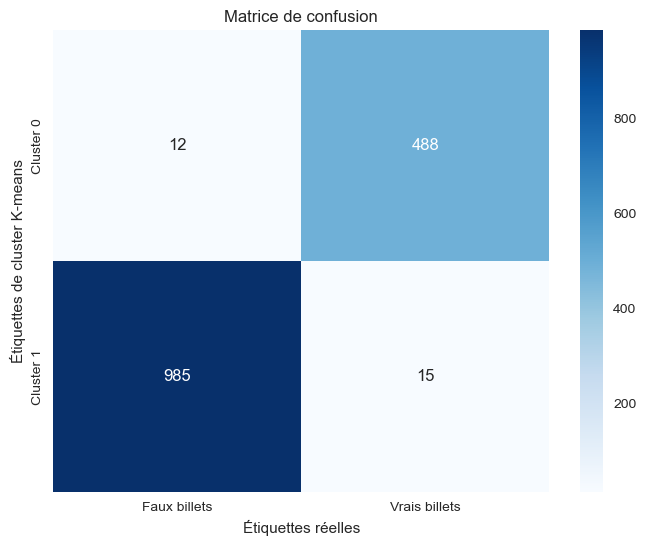

In [65]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Je définis la variable à prédire.
variable_a_predire = df['is_genuine']

# Les étiquettes prédites à partir du modèle K-means.
labels_predits = labels  

# Je vérifie que les longueurs de 'variable_a_predire' et 'labels_predits' sont les mêmes.
if len(variable_a_predire) != len(labels_predits):
    print("Erreur : Les longueurs de 'variable_a_predire' et 'labels_predits' ne correspondent pas.")
else:
    # Je calcule la matrice de confusion.
    matrice_confusion = confusion_matrix(variable_a_predire, labels_predits)
    
    # Je l'affiche.
    print("Matrice de confusion :")
    print(matrice_confusion)
    
    # Je visualise la matrice de confusion.
    plt.figure(figsize=(8, 6))
    sns.heatmap(matrice_confusion, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Faux billets', 'Vrais billets'],
                yticklabels=['Cluster 0', 'Cluster 1'])
    plt.ylabel('Étiquettes de cluster K-means')
    plt.xlabel('Étiquettes réelles')
    plt.title('Matrice de confusion')
    plt.show()


Creation du modele de régression logistique

Précision du modèle initial : 0.9933333333333333
Rapport de classification :
              precision    recall  f1-score   support

       False       0.99      0.99      0.99       110
        True       0.99      0.99      0.99       190

    accuracy                           0.99       300
   macro avg       0.99      0.99      0.99       300
weighted avg       0.99      0.99      0.99       300

Valeurs de VIF :


,caractéristique,VIF
0,diagonal,1.014457
1,height_left,1.149984
2,height_right,1.259513
3,margin_low,1.929765
4,margin_up,1.423355
5,length,2.213205


c:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Meilleurs hyperparamètres :
{'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}
Meilleur score : 0.9908333333333333
Récapitulatif des résultats :
                        Mesure    Valeur
0                    Précision  0.993333
1  Meilleur score (GridSearch)  0.990833


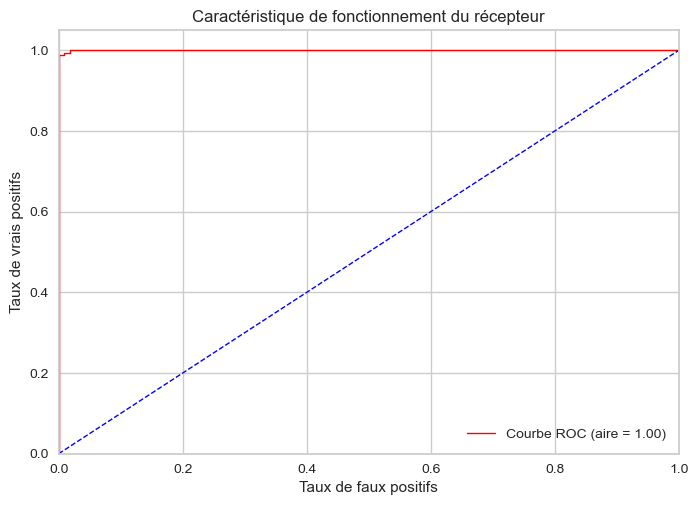

In [66]:
# Je commence par importer les bibliothèques nécessaires
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from statsmodels.stats.outliers_influence import variance_inflation_factor
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler  # Nouvel import

# Je charge les données depuis le fichier CSV
chemin_fichier = 'df_model_reg.csv'
df = pd.read_csv(chemin_fichier)

# Je divise les données en ensembles d'entraînement et de test
X = df.drop('is_genuine', axis=1)
y = df['is_genuine']
X_entrainement, X_test, y_entrainement, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Je mets à l'échelle les variables à l'aide du StandardScaler
scaler = StandardScaler()
X_entrainement = scaler.fit_transform(X_entrainement)
X_test = scaler.transform(X_test)

# J'initialise et entraîne le modèle de régression logistique
reg_log = LogisticRegression(class_weight='balanced')
reg_log.fit(X_entrainement, y_entrainement)

# J'évalue la précision du modèle initial
y_pred = reg_log.predict(X_test)
precision = accuracy_score(y_test, y_pred)
rapport = classification_report(y_test, y_pred)
print("Précision du modèle initial :", precision)
print("Rapport de classification :")
print(rapport)

# Je calcule le VIF pour chaque variable indépendante
donnees_vif = pd.DataFrame()
donnees_vif["caractéristique"] = X.columns  # On utilise X.columns car X_entrainement est maintenant un array
donnees_vif["VIF"] = [variance_inflation_factor(X_entrainement, i) for i in range(X_entrainement.shape[1])]
print("Valeurs de VIF :")
display(donnees_vif)

# Je règle les hyperparamètres en utilisant GridSearchCV
grille_parametres = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga']
}
recherche_grille = GridSearchCV(LogisticRegression(), grille_parametres, cv=5, scoring='accuracy')
recherche_grille.fit(X_entrainement, y_entrainement)
meilleurs_parametres = recherche_grille.best_params_
meilleur_score = recherche_grille.best_score_
print("Meilleurs hyperparamètres :")
print(meilleurs_parametres)
print("Meilleur score :", meilleur_score)

# Je crée un DataFrame pour le récapitulatif
recap = pd.DataFrame({
    'Mesure': ['Précision', 'Meilleur score (GridSearch)'],
    'Valeur': [precision, meilleur_score]
})

# J'affiche le récapitulatif des résultats
print("Récapitulatif des résultats :")
print(recap)

# Je trace la courbe ROC pour visualiser les performances du modèle
y_proba = reg_log.predict_proba(X_test)[:,1]
fpr, tpr, _ = roc_curve(y_test, y_proba)
aire_roc = roc_auc_score(y_test, y_proba)
plt.figure()
plt.plot(fpr, tpr, color='red', lw=1, label=f'Courbe ROC (aire = {aire_roc:.2f})')
plt.plot([0, 1], [0, 1], color='blue', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taux de faux positifs')
plt.ylabel('Taux de vrais positifs')
plt.title('Caractéristique de fonctionnement du récepteur')
plt.legend()
plt.show()


Matrice de confusion du modele de regression logistique

Matrice de Confusion :
[[109   1]
 [  1 189]]


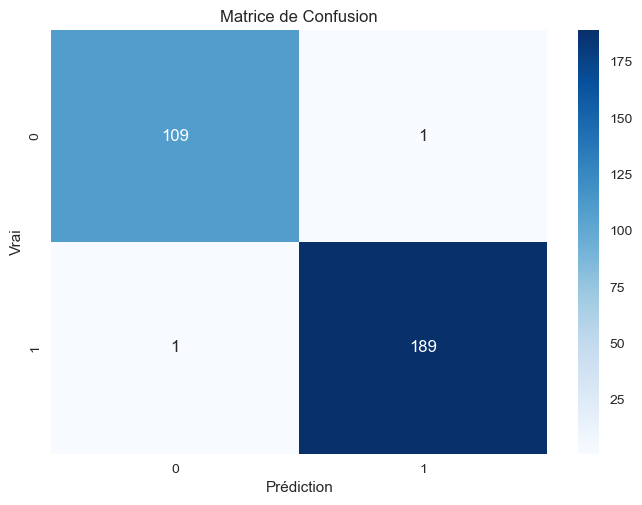

In [67]:


mat_confusion = confusion_matrix(y_test, y_pred)
print("Matrice de Confusion :")
print(mat_confusion)

# Visualisation de la matrice de confusion
sns.heatmap(mat_confusion, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Prédiction')
plt.ylabel('Vrai')
plt.title('Matrice de Confusion')
plt.show()

Sauvegarde du modele de regression logistique

In [68]:
import pickle

# Sauvegarder le modèle dans un fichier .pkl
pickle.dump(reg_log, open("model_final_.pkl", "wb"))   